In [5]:
import csv
from typing import Optional

import arrow
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Sequential
from keras.src.layers import LSTM, Dropout, Dense
from pandas import DatetimeIndex
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# 可视化结果（如果需要）
import matplotlib.pyplot as plt
import os
import pathlib
import xml.etree.ElementTree as ET
import xarray as xr
import codecs
import datetime

# 先从海浪数据中提取出经纬度，时间，风，海浪高度
# 解析单个文件，并存于字典内
from sklearn.preprocessing import StandardScaler

In [6]:
def batch_get_realdata(file_full_path: str, split_hours=72, issue_hours_steps: int = 12) -> pd.DataFrame:
    """
        TODO:[-] 25-04-23 生成实况训练数据集
        从指定文件批量获取时间数据并以dataframe的形式返回
    :param file_full_path:
    :return:
    """

    """
        eg: csv文件样例:
                        time	longitude	latitude	WS	YBG
                        202401010000
                        YYYYMMDDHHmm
    """
    list_series = []
    merge_dict = {}
    if pathlib.Path(file_full_path).exists():
        # ds: xr.Dataset = xr.open_dataset(file_full_path)
        df: pd.DataFrame = pd.read_csv(file_full_path)
        """读取指定路径的浮标处理后的一年的数据"""
        # 通过起止时间找到对应的index，然后每次的发布时间间隔步长为12h

        # step1: 生成2024年一年的时间步长为1hour的时间索引集合
        # TODO:[-] 25-05-12 注意此部分修改起止时间 local time -> utc time
        start_time = '2024-01-01 00:00:00'
        end_time = '2024-12-31 23:00:00'
        start_time_utc = '2023-12-31 16:00:00'
        end_time_utc = '2024-12-31 15:00:00'
        time_series = pd.date_range(start=start_time, end=end_time, freq='H')

        # 将time列的内容从int64 => str
        df['time'] = df['time'].astype(str)
        df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H%M')
        # step2: 将 time列设置为index，并将index替换为标准时间集合
        df.set_index('time', inplace=True)
        # TODO:[-] 25-05-12 注意直接重设index会造成所有数据为 nan 的情况。 解决办法：先创建新的utc_times 再设置为索引列
        # ValueError: Length of values (8784) does not match length of index (8887)

        df_reindexed = df.reindex(time_series)
        utc_times = pd.date_range(start=start_time_utc, end=end_time_utc, freq='H', tz='utc')
        df_reindexed['utc_times'] = utc_times
        df_reindexed = df_reindexed.set_index('utc_times')
        # 此处不需要再删除 time了，因为 index 已经 utc_times -> index了
        # df_reindexed = df_reindexed.drop('time', axis=1)
        df_reindexed.index.name = 'time'

        # step3: 生成12小时为间隔的时间数组
        freq_str: str = f'{issue_hours_steps}H'
        start_time_split_utc: str = '2024-01-01 00:00:00'
        end_time_split_utc: str = '2024-12-31 23:00:00'
        issue_dt_series = pd.date_range(start=start_time_split_utc, end=end_time_split_utc, freq=freq_str, tz='utc')

        for temp_time in issue_dt_series:
            temp_index: int = df_reindexed.index.get_loc(temp_time)
            val_series = df_reindexed[temp_index:temp_index + split_hours]
            list_series.append(val_series)
        # TODO:[-] 25-04-24 此处做重新修改，拼接成一个dataframe

        for temp_time in issue_dt_series:
            dt_str: str = temp_time.strftime('%Y%m%d%H%M%S')
            temp_index: int = df_reindexed.index.get_loc(temp_time)
            val_series = df_reindexed[temp_index:temp_index + split_hours]
            # 此处改为只取 'WS' 列
            # TODO:[-] 25-04-24 住一次此处需要将每一个 series的index索引重置为 [0,71]
            merge_dict[dt_str] = val_series['WS'].reset_index(drop=True)
            # list_series.append(val_series)
    df = pd.DataFrame.from_dict(merge_dict)
    # TODO:[-] 25-05-11 注意此处的 columns 为 字符串，需要将 str -> datetime
    df.columns = pd.to_datetime(df.columns)
    return df

In [7]:
def get_test_array(test_read_path: str, training_read_path: str, issue_times_index: DatetimeIndex):
    """
        分别读取测试数据集以及实况数据集并进行训练
    :param test_read_path:
    :param training_read_path:
    :return:
    """
    if pathlib.Path(test_read_path).exists() and pathlib.Path(training_read_path).exists():
        df_test: pd.DataFrame = pd.read_csv(test_read_path)
        u_data_dict = {}
        v_data_dict = {}
        # 读取的预报风场——测试训练集 在 df 中是通过 xxx_u与 xxx_v 的形式进行存储
        # TODO:[-] 25-04-28 u 与 v 每个共613组预报数据
        for col_name in df_test.columns:
            try:
                col_vector = df_test[col_name]
                # yyyymmddhhss
                dt_temp_str: str = col_name.split('_')[0]
                # u or v
                var_temp_str: str = col_name.split('_')[1]
                if var_temp_str == 'u':
                    # u_data_dict[dt_temp_str] = col_vector.tolist()
                    u_data_dict[dt_temp_str] = col_vector
                elif var_temp_str == 'v':
                    # v_data_dict[dt_temp_str] = col_vector.tolist()
                    v_data_dict[dt_temp_str] = col_vector
                print(f'当前列:{col_name}处理成功~')
            except Exception as e:
                print(f'当前列:{col_name}处理错误!')
        # # step2: 将字典统一转换为二维数组
        # result_u_array = [val for key, val in u_data_dict.items()]
        # result_v_array = [val for key, val in v_data_dict.items()]
        # return [result_u_array, result_v_array]
        df_u = pd.DataFrame.from_dict(u_data_dict)
        df_v = pd.DataFrame.from_dict(v_data_dict)
        # 将时间字符串=>datetime
        df_u.columns = pd.to_datetime(df_u.columns)
        df_v.columns = pd.to_datetime(df_v.columns)
        # TODO:[*] 25-04-29
        # 需要根据起止时间及时间步长，生成对应的时间索引，并将该时间索引作为标准索引
        # 注意： reindex 后会返回一个新的 DataFrame，并不会修改原始df
        df_u = df_u.reindex(columns=issue_times_index)
        df_v = df_v.reindex(columns=issue_times_index)
        return df_u, df_v
        # pass
    return None

In [8]:
read_path: str = r'Z:\WIND\GRAPES\2024'
out_put_path: str = r'./data'
out_put_file_path: str = str(pathlib.Path(out_put_path) / 'GRAPES_2024_24')
lat: float = 39.5003
lng: float = 120.59533
# TODO:[*] 25-04-29 根据起止时间，时间步长为12h，生成发布时间index
start_time = '2024-01-01 00:00:00'
end_time = '2024-12-31 23:00:00'
issue_times_index = pd.date_range(start=start_time, end=end_time, freq='12h')
# step1: 提取数据集
df_u, df_v = get_test_array(r'G:\05DATA\01TRAINING_DATA\WIND\merge.csv',
                            r'G:\05DATA\01TRAINING_DATA\FUB\MF01001\2024_local.csv', issue_times_index)
read_file_full_path: str = r'G:\05DATA\01TRAINING_DATA\FUB\MF01001\2024_local.csv'
#  生成一年的 365*2 =730 个 ws,ybg -> 只取 ws
# 注意实况 shape : (72,732)
df_ws = batch_get_realdata(read_file_full_path)
"""shape:(72,732)"""
df_ws_subset = df_ws.iloc[:25, :]
# TODO:[-] 25-05-08 将 u+v获得 ws的风速的值
df_ws_forecast = np.sqrt(df_u ** 2 + df_v ** 2)
"""风场的风速绝对值"""
# shape :(25,732)
df_ws_forecast = pd.DataFrame(df_ws_forecast)
print(f'df_ws_forecast shape:{df_ws_forecast.shape}')
print(f'df_ws_subset shape:{df_ws_subset.shape}')


当前列:Unnamed: 0.10处理错误!
当前列:20240101000000_u处理成功~
当前列:20240101000000_v处理成功~
当前列:20240101120000_u处理成功~
当前列:20240101120000_v处理成功~
当前列:20240102000000_u处理成功~
当前列:20240102000000_v处理成功~
当前列:20240102120000_u处理成功~
当前列:20240102120000_v处理成功~
当前列:20240103000000_u处理成功~
当前列:20240103000000_v处理成功~
当前列:20240103120000_u处理成功~
当前列:20240103120000_v处理成功~
当前列:20240104000000_u处理成功~
当前列:20240104000000_v处理成功~
当前列:20240104120000_u处理成功~
当前列:20240104120000_v处理成功~
当前列:20240105000000_u处理成功~
当前列:20240105000000_v处理成功~
当前列:20240105120000_u处理成功~
当前列:20240105120000_v处理成功~
当前列:20240106000000_u处理成功~
当前列:20240106000000_v处理成功~
当前列:20240106120000_u处理成功~
当前列:20240106120000_v处理成功~
当前列:20240107000000_u处理成功~
当前列:20240107000000_v处理成功~
当前列:20240107120000_u处理成功~
当前列:20240107120000_v处理成功~
当前列:20240108000000_u处理成功~
当前列:20240108000000_v处理成功~
当前列:20240108120000_u处理成功~
当前列:20240108120000_v处理成功~
当前列:20240109000000_u处理成功~
当前列:20240109000000_v处理成功~
当前列:20240109120000_u处理成功~
当前列:20240109120000_v处理成功~
当前列:20240110000000_u处理成功~
当前列:20240110000

C:\Users\evase\AppData\Local\Temp\ipykernel_31688\3986186089.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_series = pd.date_range(start=start_time, end=end_time, freq='H')
C:\Users\evase\AppData\Local\Temp\ipykernel_31688\3986186089.py:40: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  utc_times = pd.date_range(start=start_time_utc, end=end_time_utc, freq='H', tz='utc')
C:\Users\evase\AppData\Local\Temp\ipykernel_31688\3986186089.py:51: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  issue_dt_series = pd.date_range(start=start_time_split_utc, end=end_time_split_utc, freq=freq_str, tz='utc')


df_ws_forecast shape:(25, 732)
df_ws_subset shape:(25, 732)


In [9]:
# TODO:[*] 25-05-11 由于数据可能存在空置（大概40个预报时次，20天没有预报数据)
# 删除 df_ws_forecast 中的空值，并获取有效索引
# axis=1 按列检索，若列中存在nan则删除该列
valid_columns = df_ws_forecast.dropna(axis=1).columns
# 使用有效索引筛选 df_ws_forecast 和 df_ws_subset
df_ws_forecast_cleaned = df_ws_forecast[valid_columns]
df_ws_subset_cleaned = df_ws_subset[valid_columns]
print(f'df_ws_forecast_cleaned shape:{df_ws_forecast_cleaned.shape}')
print(f'df_ws_subset_cleaned shape:{df_ws_subset_cleaned.shape}')
print(f'df_ws_forecast_cleaned中包含 NaN 的行数:{df_ws_forecast_cleaned.isnull().any(axis=0).sum()}')
print(f'df_ws_subset_cleaned NaN 的行数:{df_ws_subset_cleaned.isnull().any(axis=0).sum()}')
print('# ————————————————————————————————————————————')
# ————————————————————————————————————————————
# 使用线性插值填充 NaN 值
df_interpolated = df_ws_subset_cleaned.interpolate(method='linear')
print(f'df_interpolated中包含 NaN 的行数:{df_interpolated.isnull().any(axis=0).sum()}')
print('# ————————————————————————————————————————————')
# 由于实况数据中也可能包含nan，需要找到实况数据中的nan的行，并双向删除
# TODO:[-] 25-05-11
# axis=0 ，表示按行进行操作 ; axis=1，表示按列进行操作 .
valid_realdata_columns = df_interpolated.dropna(axis=1).columns
df_ws_forecast_cleaned = df_ws_forecast[valid_realdata_columns]
df_ws_subset_cleaned = df_interpolated[valid_realdata_columns]
print(f'df_ws_forecast_cleaned shape:{df_ws_forecast_cleaned.shape}')
print(f'df_ws_subset_cleaned shape:{df_ws_subset_cleaned.shape}')
print(f'df_ws_forecast_cleaned中包含 NaN 的行数:{df_ws_forecast_cleaned.isnull().any(axis=0).sum()}')
print(f'df_ws_subset_cleaned NaN 的行数:{df_ws_subset_cleaned.isnull().any(axis=0).sum()}')
print('# ————————————————————————————————————————————')

df_ws_forecast_cleaned shape:(25, 612)
df_ws_subset_cleaned shape:(25, 612)
df_ws_forecast_cleaned中包含 NaN 的行数:0
df_ws_subset_cleaned NaN 的行数:37
# ————————————————————————————————————————————
df_interpolated中包含 NaN 的行数:4
# ————————————————————————————————————————————
df_ws_forecast_cleaned shape:(25, 608)
df_ws_subset_cleaned shape:(25, 608)
df_ws_forecast_cleaned中包含 NaN 的行数:0
df_ws_subset_cleaned NaN 的行数:0
# ————————————————————————————————————————————


In [10]:
rows: int = df_ws_forecast_cleaned.shape[0]
cols: int = df_ws_forecast_cleaned.shape[1]
X = df_ws_forecast_cleaned.values.T.reshape(cols, rows, 1)
# TODO:[*] 25-05-11 注意 y 中有存在 nan
y = df_ws_subset_cleaned.values.T.reshape(cols, rows, 1)
# TODO:[-] 25-05-11 由于输出结果均为 nan，排查输入的 X 与 y 是否存在 nan
if np.isnan(X).any() or np.isnan(y).any():
    print("数据中存在 NaN 值，请处理。")
print(f'df_ws_forecast.T-> X shape:{X.shape}')
print(f'df_ws_subset.T-> y shape:{y.shape}')
"""
    df_ws_forecast.T-> X shape:(732, 25, 1)
    df_ws_subset.T-> y shape:(732, 25, 1)
"""
# 设置时间步长为 25
n_timesteps = 24
# 25 相当于样本数也是25
n_samples = df_ws_forecast_cleaned.shape[0]
# step3: 数据划分
# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# step4: 创建 LSTM 模型
model = Sequential()
# 25 时间步长，1个特征
model.add(LSTM(50, activation='relu', input_shape=(25, 1)))
# TODO:[*] 25-05-11 此处的意义
# model.add(Dropout(0.2))  # 防止过拟合
model.add(Dense(25))  # 输出层，预测 25 个时间步的值
# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')
# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

df_ws_forecast.T-> X shape:(608, 25, 1)
df_ws_subset.T-> y shape:(608, 25, 1)


c:\Users\evase\Anaconda3\envs\py39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 51.7734 - val_loss: 23.0583
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 20.8889 - val_loss: 10.7784
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 11.4351 - val_loss: 8.5661
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.4922 - val_loss: 9.4159
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 10.6445 - val_loss: 7.4787
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.5478 - val_loss: 7.3125
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 8.8238 - val_loss: 7.7463
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.3850 - val_loss: 7.0087
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.4694 - val_loss: 6.8685
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.5472 - val_loss: 6.7123
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.4665 - val_loss: 6.8278
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20m

In [9]:
y_test.shape

(122, 25, 1)

In [10]:
predictions.shape

(122, 25)

In [11]:
# step5: 模型预测
# 进行预测
predictions = model.predict(X_test)
# 输出预测结果的形状
print("Predictions shape:", predictions.shape)  # 应为 (147, 25)
# 评估模型
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Predictions shape: (122, 25)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.2338
Test Loss: 5.355242729187012


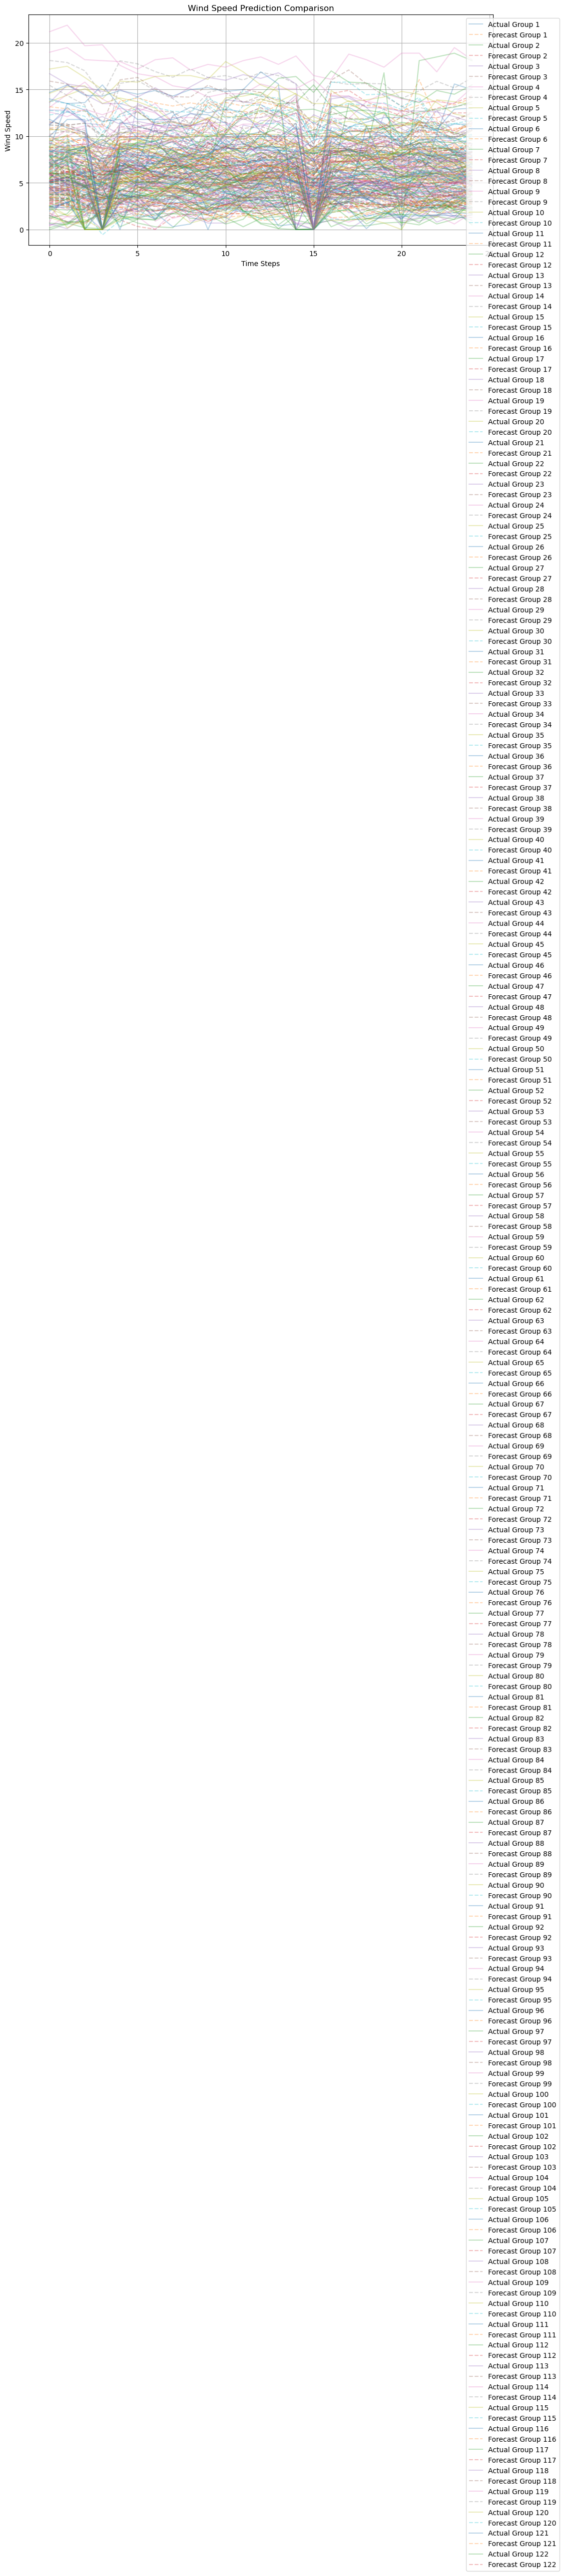

In [12]:
import matplotlib.pyplot as plt

# 假设 y_test 和 predictions 已经定义
num_groups = y_test.shape[0]  # 122组数据
time_steps = y_test.shape[1]  # 25小时

# 创建一个图形
plt.figure(figsize=(12, 6))

# 绘制每组的曲线图
for i in range(num_groups):
    plt.plot(y_test[i].flatten(), label=f'Actual Group {i + 1}', alpha=0.3)  # 设置透明度
    plt.plot(predictions[i], label=f'Forecast Group {i + 1}', linestyle='--', alpha=0.3)

# 添加标题和标签
plt.title('Wind Speed Prediction Comparison')
plt.xlabel('Time Steps')
plt.ylabel('Wind Speed')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))  # 位置调整
plt.grid()
plt.show()


In [ ]:
# 选择第一个样本进行可视化
import matplotlib
matplotlib.use('TkAgg')  # 或者使用 'Qt5Agg'
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test[0], label='Actual', color='blue')
plt.plot(predictions[0], label='Forecast', color='red')
plt.title('Wind Speed Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

: 